# Policy Evaluation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.optimization.lp_solve import news_solver

In [18]:
df = pd.read_csv("../data/raw/online_news_popularity/OnlineNewsPopularity\OnlineNewsPopularity.csv")
df_lp = pd.read_csv("../data/processed/lp_dataset.csv")

In [19]:
popularity = df[' shares'].to_numpy()

topics = df_lp['topics'].to_numpy()
images = df_lp[' num_imgs'].to_numpy()
hrefs = df_lp[' num_hrefs'].to_numpy()
keywords = df_lp[' kw_avg_avg'].to_numpy()
tech_indicator = df_lp[' data_channel_is_tech'].to_numpy()
other_indicator = df_lp[' data_channel_is_other'].to_numpy()

## `Others` Topic Margin

The following section evaluates the trade-offs in the constraint related to `others` topic.

In [9]:
other_lower_bounds = [i for i in range(11)]
other_shares = []

for i in other_lower_bounds:
    selected_indices, status = news_solver(
    popularity=popularity,
    topics=topics,
    images=images,
    hrefs=hrefs,
    keywords=keywords,
    tech_indicator=tech_indicator,
    other_indicator=other_indicator,
    other_lower_bound=i,
    avg_images=images.mean(),
    avg_hrefs=hrefs.mean(),
    avg_keywords=keywords.mean()
    )

    lp_shares = df_lp.iloc[selected_indices][' shares'].sum()
    other_shares.append(lp_shares)


c:\Users\nguye\news-promotion-lp\venv\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Text(0, 0.5, 'Optimal Shares')

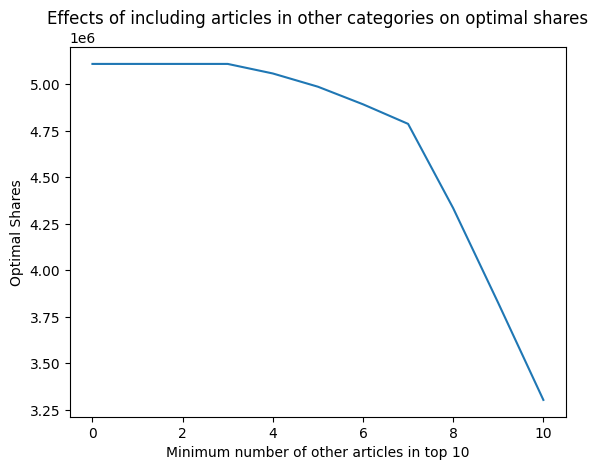

In [13]:
plt.plot(other_lower_bounds, other_shares)
plt.title("Effects of including articles in other categories on optimal shares")
plt.xlabel("Minimum number of other articles in top 10")
plt.ylabel("Optimal Shares")

We notice that including too many articles in the other categories is negatively affects the optimal shares. To accomodate the business stakeholders' requirements of including these articles, we should choose AT MOST 3 articles from the other catgories.

## Technology Coefficient
In the EDA step, we noticed that Technology articles are accounted for the most shares, so the stakeholders wanted to prioritize them in the new feeds. Hence, we have included a weight for these article (lambda_tech). However, we need to determine which value should lambda_tech be to balance topic diversity?

In [22]:
lambdas = [0, 5, 10, 20, 50, 1000]
results = []

for lam in lambdas:
    selected_indices, status = news_solver(
    popularity=popularity,
    topics=topics,
    images=images,
    hrefs=hrefs,
    keywords=keywords,
    tech_indicator=tech_indicator,
    other_indicator=other_indicator,
    other_lower_bound=2,
    avg_images=images.mean(),
    avg_hrefs=hrefs.mean(),
    avg_keywords=keywords.mean(),
    lambda_tech=lam
    )

    results.append({
        "lambda_tech": lam,
        "n_selected": len(selected_indices),
        "n_tech": df_lp.loc[selected_indices, " data_channel_is_tech"].sum(),
        "avg_images": df_lp.loc[selected_indices, " num_imgs"].mean(),
        "avg_hrefs": df_lp.loc[selected_indices, " num_hrefs"].mean(),
        "objective": sum(df_lp.loc[selected_indices, " shares"] + lam * df_lp.loc[selected_indices, " data_channel_is_tech"].sum())
    }) 

In [23]:
results

[{'lambda_tech': 0,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5109100.0},
 {'lambda_tech': 5,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5109150.0},
 {'lambda_tech': 10,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5109200.0},
 {'lambda_tech': 20,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5109300.0},
 {'lambda_tech': 50,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5109600.0},
 {'lambda_tech': 1000,
  'n_selected': 10,
  'n_tech': np.float64(1.0),
  'avg_images': np.float64(8.0),
  'avg_hrefs': np.float64(14.0),
  'objective': 5119100.0}]

Despite technology articles are very popular, the optimal number of them is one technology article. Hence, in our final model, we can exclude lambda_tech for simplicity.